<a href="https://colab.research.google.com/github/ahnjonghyunn/ABC/blob/main/%EB%B2%A1%ED%84%B0db_%EC%95%88%EC%A2%85%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import zipfile

# 1) 압축 풀기
local_zip = '/content/raccoon_dog_raccoon.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False)

def image_to_vector(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    vector = base_model.predict(img_array)
    vector = vector.flatten()
    return vector

def process_images_in_folder(folder_path):
    image_vectors = []

    # 폴더 내의 모든 파일에 대해 반복
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # jpg 확장자인 파일만 처리
            image_path = os.path.join(folder_path, filename)
            image_vector = image_to_vector(image_path)
            image_vectors.append(image_vector)

    return image_vectors

# 이미지가 들어있는 폴더의 경로 설정
folder_path_1 = '/content/raccoon_dog_raccoon/raccoon' # 1이 라쿤임
folder_path_2 = '/content/raccoon_dog_raccoon/raccoon_dog' # 2가 너구리임.

folder_path_3 = folder_path_1 + folder_path_2

# 폴더 내의 모든 이미지에 대해 벡터 추출
all_image_vectors_1 = process_images_in_folder(folder_path=folder_path_1)
all_image_vectors_2 = process_images_in_folder(folder_path=folder_path_2)

# 두 폴더에서 얻은 벡터들을 이어붙임
all_image_vectors = all_image_vectors_1 + all_image_vectors_2

# 결과 확인
print(f"Number of images processed: {len(all_image_vectors)}")


1/1 [==============================] - 0s 23ms/step
Number of images processed: 446


In [ ]:
import faiss
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import shutil

# InceptionV3 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False)

def image_to_vector(image_path, base_model):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    vector = base_model.predict(img_array)
    vector = vector.flatten()
    return vector

# 벡터 데이터베이스 초기화
dimension = len(all_image_vectors[0])  # 이미지 벡터의 차원
database = faiss.IndexFlatL2(dimension)

# 이미지 벡터를 데이터베이스에 추가
image_vectors_array = np.array(all_image_vectors).astype('float32')
database.add(image_vectors_array)

def search_similar_images(new_image_vector, k=5):
    # 새로운 이미지와 데이터베이스 이미지 간의 유사도 검색
    _, similar_indices = database.search(np.array([new_image_vector]), k=k)
    return similar_indices.flatten()



In [ ]:
# 예시: 새로운 이미지 경로 설정
new_image_path = '/content/raccoon_dog_naver.jpg'

# 새로운 이미지 벡터 추출
new_image_vector = image_to_vector(new_image_path, base_model)

# 유사한 이미지 검색
similar_indices = search_similar_images(new_image_vector, k=5)

# 가장 유사한 이미지의 인덱스 출력
print("Most similar images indices:", similar_indices)

1/1 [==============================] - 1s 906ms/step
Most similar images indices: [189 117  54 115 333]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 파일들이 있는 폴더 경로
image_folder_path1 = '/content/raccoon_dog_raccoon/raccoon'
image_folder_path2 = '/content/raccoon_dog_raccoon/raccoon_dog'
image_folder_path = os.path.join(image_folder_path1, image_folder_path2)

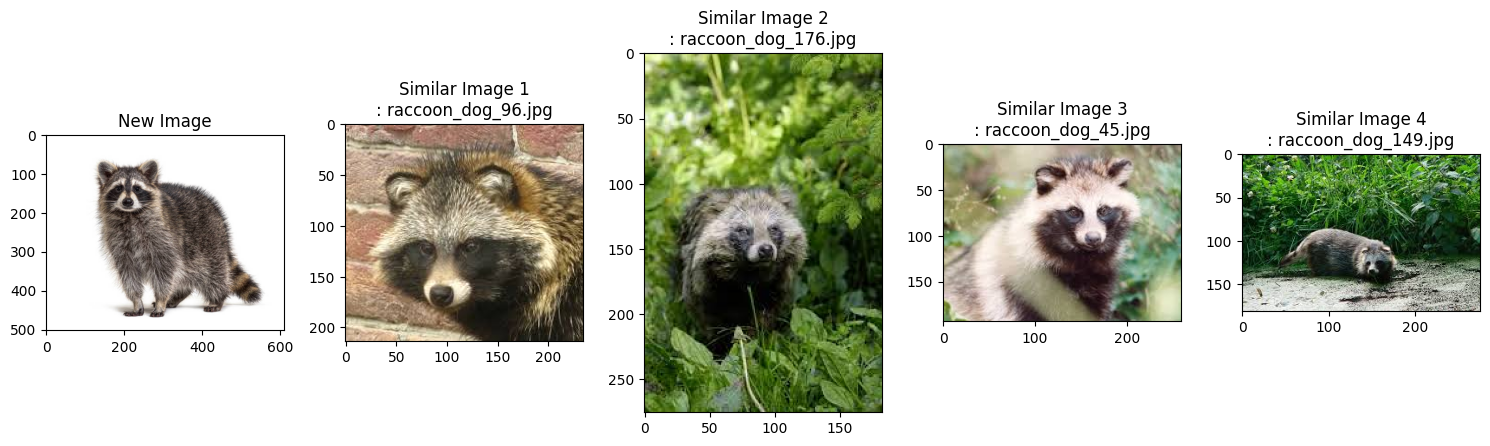

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML

# ...
# 유사한 이미지들을 저장할 리스트
similar_images = []

# 검색된 가장 유사한 이미지들의 인덱스를 이용하여 파일 경로를 가져와 리스트에 추가
for index in similar_indices:
    # 파일 목록 가져오기
    file_list = os.listdir(image_folder_path)

    # 인덱스가 파일 목록의 범위를 벗어나지 않는지 확인
    if 0 <= index < len(file_list):
        similar_image_path = os.path.join(image_folder_path, file_list[index])
        similar_images.append(similar_image_path)

# 결과 확인을 위해 유사한 이미지들을 출력
fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

# 새로운 이미지 출력
new_image = mpimg.imread(new_image_path)
axes[0].imshow(new_image)
axes[0].set_title('New Image')

# 가장 유사한 이미지들 출력
for i, similar_image_path in enumerate(similar_images):
    similar_image = mpimg.imread(similar_image_path)
    original_image_filename = os.path.basename(os.listdir(image_folder_path)[similar_indices[i]])
    axes[i + 1].imshow(similar_image)
    axes[i + 1].set_title(f'Similar Image {i + 1}\n: {original_image_filename}')

plt.tight_layout()
plt.show()


In [ ]:
# 예시: 저장할 디렉토리 설정
output_directory = '/content/output_images/'

# 디렉토리가 없다면 생성
os.makedirs(output_directory, exist_ok=True)

In [ ]:
print(os.listdir(folder_path_1))

['raccoon_115.jpg', 'raccoon_62.jpg', 'raccoon_169.jpg', 'raccoon_27.jpg', 'raccoon_210.jpg', 'raccoon_218.jpg', 'raccoon_68.jpg', 'raccoon_201.jpg', 'raccoon_161.jpg', 'raccoon_151.jpg', 'raccoon_41.jpg', 'raccoon_7.jpg', 'raccoon_182.jpg', 'raccoon_38.jpg', 'raccoon_116.jpg', 'raccoon_122.jpg', 'raccoon_165.jpg', 'raccoon_57.jpg', 'raccoon_204.jpg', 'raccoon_1.jpg', 'raccoon_110.jpg', 'raccoon_44.jpg', 'raccoon_127.jpg', 'raccoon_59.jpg', 'raccoon_114.jpg', 'raccoon_24.jpg', 'raccoon_179.jpg', 'raccoon_159.jpg', 'raccoon_190.jpg', 'raccoon_33.jpg', 'raccoon_2.jpg', 'raccoon_189.jpg', 'raccoon_217.jpg', 'raccoon_103.jpg', 'raccoon_134.jpg', 'raccoon_34.jpg', 'raccoon_177.jpg', 'raccoon_120.jpg', 'raccoon_50.jpg', 'raccoon_88.jpg', 'raccoon_13.jpg', 'raccoon_11.jpg', 'raccoon_10.jpg', 'raccoon_133.jpg', 'raccoon_199.jpg', 'raccoon_85.jpg', 'raccoon_65.jpg', 'raccoon_207.jpg', 'raccoon_150.jpg', 'raccoon_72.jpg', 'raccoon_184.jpg', 'raccoon_53.jpg', 'raccoon_6.jpg', 'raccoon_80.jpg', 'r

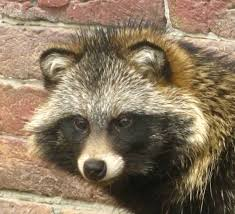

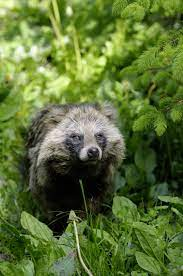

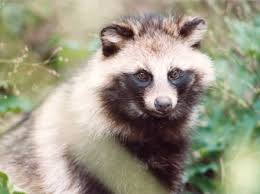

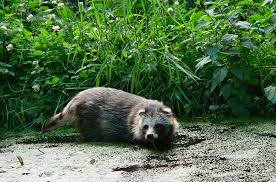

Index 333 is out of range for the file list.


In [ ]:
# 이미지 파일 이름 변경 및 저장
for i, index in enumerate(similar_indices):
    file_list = os.listdir(image_folder_path)

    # Check if the index is within the valid range
    if 0 <= index < len(file_list):
        original_image_path = os.path.join(image_folder_path, file_list[index])
        new_image_path = os.path.join(output_directory, f'similar_image_{i}.jpg')
        shutil.copy(original_image_path, new_image_path)

        # 이미지 출력과 함께 파일 이름 표시
        display(HTML(f"<p style='text-align: center;'>Similar Image {i}</p>"))
        display(Image(filename=new_image_path))
        display(HTML(f"<p style='text-align: center;'>{os.path.basename(original_image_path)}</p>"))
    else:
        print(f"Index {index} is out of range for the file list.")